In [1]:
## Importing Libraries
import time
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#default parameters
plt.rcParams['lines.linewidth'] = 1
import datetime as dt
from functools import reduce
from datetime import datetime, timedelta
import bamboolib

import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest

import darts
from darts import TimeSeries

from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta,
    XGBModel
)
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox


from darts.datasets import AirPassengersDataset, AusBeerDataset, GasRateCO2Dataset 
from darts.datasets import HeartRateDataset, IceCreamHeaterDataset, MonthlyMilkDataset
from darts.datasets import SunspotsDataset


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

t_start1 = time.perf_counter()
%matplotlib inline

#default parameters
plt.rcParams['lines.linewidth'] = 1
MSEAS = 12                    # seasonality default
ALPHA = 0.05                  # significance level default


max_dat = dt.datetime(2017,8,15).date() 
# example timestamp
new_timestamp = max_dat - timedelta(days=60)

print('train data end date:',new_timestamp)
print('validation end date:',max_dat)

TRAIN = new_timestamp                           # training Favorita -60 dagen 


train data end date: 2017-06-16
validation end date: 2017-08-15


In [2]:
print("Darts version:", darts.__version__)
print("Pandas version:", pd.__version__)
print("Bamboolib version:", bamboolib.__version__)
print("NumPy version:", np.__version__)

Darts version: 0.24.0
Pandas version: 1.5.2
Bamboolib version: 1.30.19
NumPy version: 1.23.5


In [3]:
def wape_with_penalty(df):
    actual = df['actual']
    forecast = df['forecast']
    abs_error = np.abs(actual - forecast)
    penalty = np.where(forecast > actual, 1.1, 1)
    wape = np.sum(penalty * abs_error) / np.sum(actual) * 100
    return wape

In [36]:
## load data

## stores 44,11,40,3,28
## items 502331,679926

# Define the store number and item number to filter on
store_nbr = 44
item_nbr = 679926

# Define the path to the parquet file for the specified store number
filename = f'../data/store/store_{store_nbr}.parquet'
# Read the parquet file for the specified store number
df = pd.read_parquet(filename)

##Missing dates
MissingDates = pd.date_range(start = '2013-01-02', end = '2017-08-15').difference(df.timestamp)
MissingDates



DatetimeIndex(['2013-12-25', '2014-01-01', '2014-12-25', '2015-01-01',
               '2015-12-25', '2016-01-01', '2016-12-25', '2017-01-01'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
#Add the missing data to the dataframe df

In [37]:
#select the preferred item
df_sel=df.loc[df['item_nbr'] == item_nbr]
df_sel

          timestamp         id  store_nbr  item_nbr  unit_sales  onpromotion  \
59499218 2013-01-02      32956         44    679926        46.0        False   
59499219 2013-01-03      73380         44    679926        19.0        False   
59499220 2013-01-04     113234         44    679926        22.0        False   
59499221 2013-01-05     155344         44    679926        29.0        False   
59499222 2013-01-06     197320         44    679926        30.0        False   
...             ...        ...        ...       ...         ...          ...   
59500892 2017-08-11  125053562         44    679926        16.0         True   
59500893 2017-08-12  125158896         44    679926        20.0        False   
59500894 2017-08-13  125264549         44    679926        20.0        False   
59500895 2017-08-14  125368881         44    679926        13.0        False   
59500896 2017-08-15  125471820         44    679926        10.0        False   

          day  year  month family  clas

In [38]:
df_cov.columns

Index(['level_0', 'index', 'time', 'timestamp', 'class', 'cluster',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME APPLIANCES',
       'family_HOME CARE', 'family_LADIESWEAR', 'family_LAWN AND GARDEN',
       'family_LINGERIE', 'family_LIQUOR,WINE,BEER', 'family_MAGAZINES',
       'family_MEATS', 'family_PERSONAL CARE', 'family_PET SUPPLIES',
       'family_PLAYERS AND ELECTRONICS', 'family_POULTRY',
       'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 'city_Ambato',
       'city_Babahoyo', 'city_Cayambe', 'city_Cuenca', 'city_Daule',
       'city_El Carmen', 'city_Esmeraldas', 'c

In [61]:
# Step: Select columns to add to the covariate dataframe
df_cov = df_sel[['timestamp', 'family', 'class', 'city', 'state', 'type', 'cluster']]
features = ['family', 'class', 'city', 'state', 'type', 'cluster']
df_cov
#static_cov = TimeSeries.from_dataframe(df_cov[features])
#df_cov
import pandas as pd; import numpy as np
df_cov = df_cov.reset_index()
# Step: OneHotEncode column(s) family, city, state, type
df_cov = pd.get_dummies(df_cov, columns=['family', 'city', 'state', 'type'], drop_first=True, dummy_na=False)

import pandas as pd; import numpy as np
# Step: Drop columns and, afterwards, normalized dataframe
#df_cov = df_cov.drop(columns=['index', 'timestamp'])
#df_cov = df_cov.reset_index()
df_cov = df_cov.set_index('timestamp')
import pandas as pd; import numpy as np
df_cov = df_cov.reset_index()
# Step: Drop columns
df_cov = df_cov.drop(columns=['index'])

# Step: Keep rows where timestamp == 2013-01-02
df_cov = df_cov.loc[df_cov['timestamp'] == '2013-01-02']

df_cov

               index  class  cluster  family_BABY CARE  family_BEAUTY  \
timestamp                                                               
2013-01-02  59499218   2502        5                 0              0   
2013-01-03  59499219   2502        5                 0              0   
2013-01-04  59499220   2502        5                 0              0   
2013-01-05  59499221   2502        5                 0              0   
2013-01-06  59499222   2502        5                 0              0   
...              ...    ...      ...               ...            ...   
2017-08-11  59500892   2502        5                 0              0   
2017-08-12  59500893   2502        5                 0              0   
2017-08-13  59500894   2502        5                 0              0   
2017-08-14  59500895   2502        5                 0              0   
2017-08-15  59500896   2502        5                 0              0   

            family_BEVERAGES  family_BOOKS  family

In [41]:
#static_cov fas to be dataframe not a TimeSeries object
#static_cov = TimeSeries.from_dataframe(df_cov,)

In [20]:
# Step: Drop columns
df_ts = df_sel.drop(columns=['id','family','class','type','cluster','city','state'])
df_tsi = df_ts.set_index('timestamp')
import pandas as pd; import numpy as np
df_tsi = df_tsi.reset_index()
df_tsi

            store_nbr  item_nbr  unit_sales  onpromotion  day  year  month  \
timestamp                                                                    
2013-01-02         44    679926        46.0        False    2  2013      1   
2013-01-03         44    679926        19.0        False    3  2013      1   
2013-01-04         44    679926        22.0        False    4  2013      1   
2013-01-05         44    679926        29.0        False    5  2013      1   
2013-01-06         44    679926        30.0        False    6  2013      1   
...               ...       ...         ...          ...  ...   ...    ...   
2017-08-11         44    679926        16.0         True   11  2017      8   
2017-08-12         44    679926        20.0        False   12  2017      8   
2017-08-13         44    679926        20.0        False   13  2017      8   
2017-08-14         44    679926        13.0        False   14  2017      8   
2017-08-15         44    679926        10.0        False   15  2

In [59]:
#completing the data
#We found that there are some missing dates in the timeseries.. So we would like to complete the timeseries with the missing dates and impute the values

# Set the timestamp column as the index of the DataFrame:
#df.set_index('timestamp', inplace=True)
# Generate a complete date range for the time series. 
# Assuming we want to fill in the missing dates between the minimum and maximum dates in the existing data, 
# we can use the date_range function from pandas:

min_date = df.index.min().date()
max_date = df.index.max().date()
date_range = pd.date_range(start=min_date, end=max_date, freq='D')
# Create a new DataFrame with the complete date range:
new_df = pd.DataFrame(index=date_range)
#new_df
#Fill in the missing values based on the specifications you provided:

#new_df['id'] = np.nan                                     # dont know what to fill in here
new_df['store_nbr'] = df['store_nbr'].mode()[0]           # fill the mode
new_df['item_nbr'] = df['item_nbr'].mode()[0]             # fill the mode
new_df['unit_sales'] = 0                                  # fill wit zero
new_df['onpromotion'] = df['onpromotion'].mode()[0]       # fill the mode
new_df['day'] = new_df.index.day                          # get day from datetime
new_df['year'] = new_df.index.year                        # get year from datetime
new_df['month'] = new_df.index.month                      # get month from datetime
new_df['family'] = df['family'].mode()[0]                 # fill the mode
new_df['class'] = df['class'].mode()[0]                   # fill the mode
new_df['perishable'] = df['perishable'].mode()[0]         # fill the mode
new_df['city'] = df['city'].mode()[0]                     # fill the mode 
new_df['state'] = df['state'].mode()[0]                   # fill the mode
new_df['type'] = df['type'].mode()[0]                     # fill the mode
new_df['cluster'] = df['cluster'].mode()[0]               # fill the mode  

In [74]:
import pandas as pd; import numpy as np
new_df = new_df.reset_index()
# Step: Left Join with df_cov where index=timestamp
new_df_join = pd.merge(new_df, df_cov, how='left', left_on=['index'], right_on=['timestamp'])

# Step: Drop columns
new_df_join = new_df_join.drop(columns=['onpromotion', 'family', 'city', 'state', 'type', 'timestamp'])



In [83]:
#df_variable = 'df_' + str(store_nbr)+'-'+ str(item_nbr)


#uvar_ts = TimeSeries.from_dataframe(df_ts, time_col='timestamp',value_cols=['unit_sales'], freq='D', fill_missing_dates=True)
#create multivariate TimeSeries object for DARTS
mvar_ts = TimeSeries.from_dataframe(df_ts, time_col='timestamp', static_covariates= df_cov ,freq='D', fill_missing_dates=True)

#uvar_ts = TimeSeries.from_dataframe(df_ts,time_col='timestamp',value_cols=['unit_sales'], freq='D')

# testing can be done with mvar or univar
series = uvar_ts    

In [76]:
mvar_ts.static_covariates

static_covariates  timestamp   class  cluster  family_BABY CARE  \
global_components 2013-01-02  2502.0      5.0               0.0   

static_covariates  family_BEAUTY  family_BEVERAGES  family_BOOKS  \
global_components            0.0               0.0           0.0   

static_covariates  family_BREAD/BAKERY  family_CELEBRATION  family_CLEANING  \
global_components                  0.0                 0.0              0.0   

static_covariates  ...  state_Manabi  state_Pastaza  state_Pichincha  \
global_components  ...           0.0            0.0              1.0   

static_covariates  state_Santa Elena  state_Santo Domingo de los Tsachilas  \
global_components                0.0                                   0.0   

static_covariates  state_Tungurahua  type_B  type_C  type_D  type_E  
global_components               0.0     0.0     0.0     0.0     0.0  

[1 rows x 75 columns]

In [77]:
mvar_ts.duration

Timedelta('1686 days 00:00:00')

In [78]:
mvar_ts.end_time

<bound method TimeSeries.end_time of <TimeSeries (DataArray) (timestamp: 1687, component: 8, sample: 1)>
array([[[4.40000e+01],
        [6.79926e+05],
        [4.60000e+01],
        ...,
        [2.01300e+03],
        [1.00000e+00],
        [1.00000e+00]],

       [[4.40000e+01],
        [6.79926e+05],
        [1.90000e+01],
        ...,
        [2.01300e+03],
        [1.00000e+00],
        [1.00000e+00]],

       [[4.40000e+01],
        [6.79926e+05],
        [2.20000e+01],
        ...,
...
        ...,
        [2.01700e+03],
        [8.00000e+00],
        [1.00000e+00]],

       [[4.40000e+01],
        [6.79926e+05],
        [1.30000e+01],
        ...,
        [2.01700e+03],
        [8.00000e+00],
        [1.00000e+00]],

       [[4.40000e+01],
        [6.79926e+05],
        [1.00000e+01],
        ...,
        [2.01700e+03],
        [8.00000e+00],
        [1.00000e+00]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 2013-01-02 2013-01-03 ... 2017-08-15
  * component  (compo

In [84]:
# replace 0 and NaN by backfilling
s = series.pd_series()
s.replace(0.0, np.nan, inplace=True)
s = s.fillna(method="bfill")
series = series.from_series(s)
df_series = series.pd_dataframe()



Text(0.5, 1.0, 'Time Series Plot 44-679926')

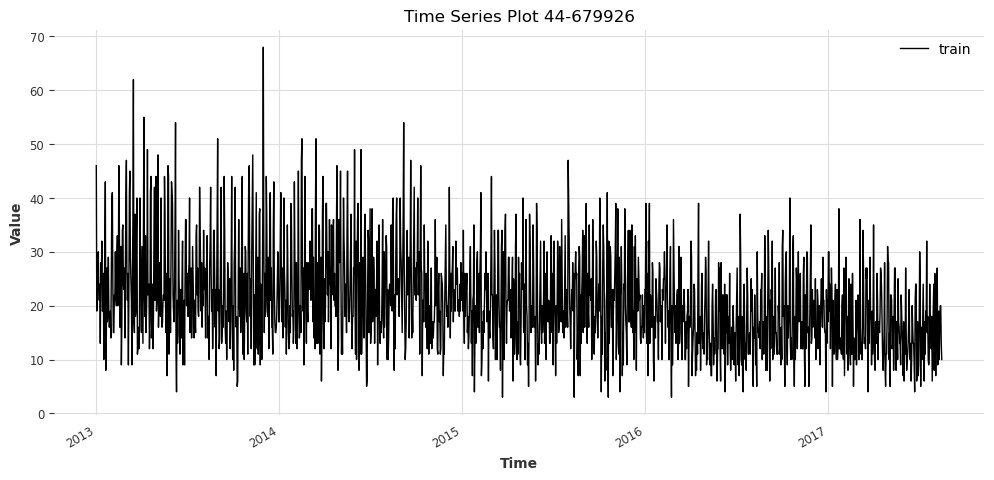

In [85]:
# plot the observations
plt.figure(100, figsize=(12, 5))
series.plot(label='train',linewidth=1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Time Series Plot {store_nbr}-{item_nbr}')

In [86]:
# check for seasonality, via ACF

for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(series, m=m, alpha=ALPHA)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))

seasonal? True
There is seasonality of order 7.


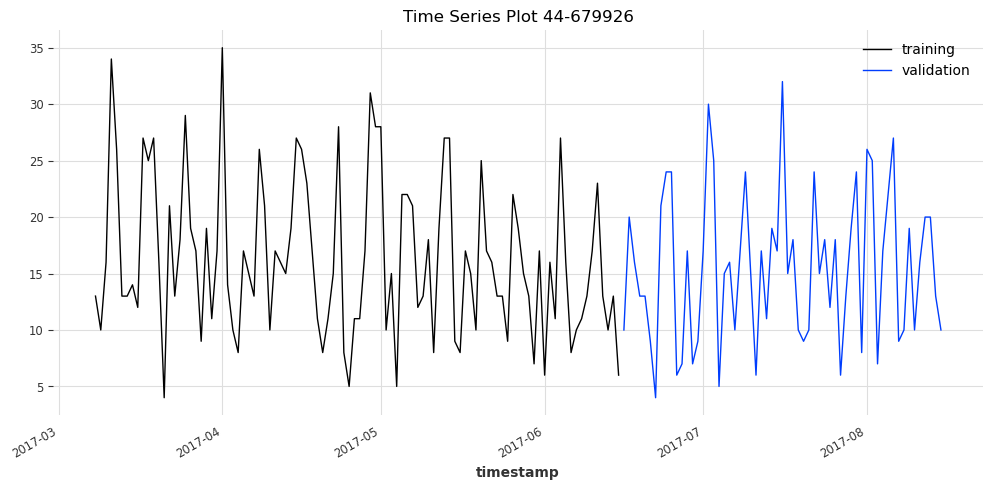

In [87]:
## split train and test data

# split position: if string, then interpret as Timestamp
# if int, then interpretation as index
# if loat, then interpretation as %split
if isinstance(TRAIN, numbers.Number):
    split_at = TRAIN
else:
    split_at = pd.Timestamp(TRAIN)
train, val = series.split_before(split_at)

plt.figure(101, figsize=(12, 5))
train.tail(100).plot(label='training',linewidth=1)  #function tail(100) shows the last 100 values of the train set
val.plot(label='validation',linewidth=1)
plt.title(f'Time Series Plot {store_nbr}-{item_nbr}')
plt.legend();

In [88]:
## fit the chosen forecaster model and compute predictions

def eval_model(model):
    t_start =  time.perf_counter()
    print("beginning: " + str(model))


    # fit the model and compute predictions
    res = model.fit(train)
    forecast = model.predict(len(val))

    # for naive forecast, concatenate seasonal fc with drift fc
    if model == m_naive:
        if is_seasonal:
            fc_drift = forecast
            modelS = NaiveSeasonal(K=mseas)
            modelS.fit(train)
            fc_seas = modelS.predict(len(val))
            forecast = fc_drift + fc_seas - train.last_value()


    # compute accuracy metrics and processing time
    res_mape = mape(val, forecast)
    res_mae = mae(val, forecast)
    res_r2 = r2_score(val, forecast)
    res_rmse = rmse(val, forecast)
    res_rmsle = rmsle(val, forecast)
    res_time = time.perf_counter() - t_start
    res_accuracy = {"MAPE":res_mape, "MAE":res_mae, "R squared":-res_r2, "RMSE":res_rmse, "RMSLE":res_rmsle, "time":res_time}

    results = [forecast, res_accuracy]
    print("completed: " + str(model) + ":" + str(res_time) + "sec")
    return results

In [89]:
# prepare Naive forecaster

m_naive = NaiveDrift()

In [90]:
# prepare Exponential Smoothing forecaster

if is_seasonal:
    m_expon = ExponentialSmoothing(seasonal_periods=mseas)
else:
    m_expon = ExponentialSmoothing()
    

In [91]:
# prepare Prophet forecaster

m_prophet = Prophet()    #frequency=mseas)

In [92]:
# prepare ARIMA forecaster

y = np.asarray(series.pd_series())
# get order of first differencing: the higher of KPSS and ADF test results
n_kpss = pmd.arima.ndiffs(y, alpha=ALPHA, test='kpss', max_d=2)
n_adf = pmd.arima.ndiffs(y, alpha=ALPHA, test='adf', max_d=2)
n_diff = max(n_adf, n_kpss)


In [93]:
# get order of seasonal differencing: the higher of OCSB and CH test results
n_ocsb = pmd.arima.OCSBTest(m=max(7,mseas)).estimate_seasonal_differencing_term(y)
#n_ch = pmd.arima.CHTest(m=max(7,mseas)).estimate_seasonal_differencing_term(y)
n_ch = 0
ns_diff = max(n_ocsb, n_ch, is_seasonal * 1)
#ns_diff = (n_ocsb,is_seasonal * 1)

In [94]:
ns_diff

1

In [95]:
# set up the ARIMA forecaster
m_arima = AutoARIMA(
    start_p=1, d=n_diff, start_q=1, 
    max_p=4, max_d=n_diff, max_q=4,
    start_P=0, D=ns_diff, start_Q=0, m=max(365,mseas), seasonal=is_seasonal,
    max_P=3, max_D=1, max_Q=3,
    max_order=5,                       # p+q+p+Q <= max_order
    stationary=False, 
    information_criterion="bic", alpha=ALPHA, 
    test="kpss", seasonal_test="ocsb",
    stepwise=True, 
    suppress_warnings=True, error_action="trace", trace=True, with_intercept="auto")

In [96]:
# prepare Theta forecaster

# search space for best theta value: check 100 alternatives
thetas = 2 - np.linspace(-10, 10, 100)

# initialize search
best_mape = float('inf')
best_theta = 0
# search for best theta among 50 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta)
    res = model.fit(train)
    pred_theta = model.predict(len(val))
    res_mape = mape(val, pred_theta)

    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta

m_theta = Theta(best_theta)   # best theta model among 100


In [97]:
# prepare XGBoost forecaster
XGBModel(lags=[-7,-6,-5,-4,-3,-1], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

m_xgboost = XGBModel

In [100]:
# laundry list of forecasters to run

models = [ 
    m_naive,
    m_expon, 
    m_theta, 
#   m_arima,
    m_prophet,
#   m_xgboost
    ]  

In [101]:
# call the forecasters one after the other

model_predictions = [eval_model(model) for model in models]

beginning: NaiveDrift()
completed: NaiveDrift():0.06454529999973602sec
beginning: ExponentialSmoothing(seasonal_periods=7)
completed: ExponentialSmoothing(seasonal_periods=7):0.4449427999998079sec
beginning: Theta(theta=-0.5252525252525242)
completed: Theta(theta=-0.5252525252525242):0.0771654000000126sec
beginning: Prophet()
completed: Prophet():0.6683838999997533sec


In [102]:
# RUN the forecasters and tabulate their prediction accuracy and processing time

df_acc = pd.DataFrame.from_dict(model_predictions[0][1], orient="index")
df_acc.columns = [str(models[0])]

for i, m in enumerate(models):
    if i > 0: 
        df = pd.DataFrame.from_dict(model_predictions[i][1], orient="index")
        df.columns = [str(m)]
        df_acc = pd.concat([df_acc, df], axis=1)
    i +=1

pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,NaiveDrift(),ExponentialSmoothing(seasonal_periods=7),Theta(theta=-0.5252525252525242),Prophet()
MAPE,30.994007,30.228732,29.534662,26.995317
MAE,4.482724,3.906267,3.961816,3.940736
R squared,-0.291530,-0.444806,-0.423492,-0.394749
RMSE,5.594934,4.952868,5.047043,5.171326
RMSLE,0.377754,0.326250,0.327157,0.329225
time,0.064545,0.444943,0.077165,0.668384


In [103]:
# RUN the forecasters and tabulate their prediction accuracy and processing time - exclude the Naive forecast

df_acc = pd.DataFrame.from_dict(model_predictions[0][1], orient="index")
df_acc.columns = [str(models[0])]

for i, m in enumerate(models):
    if i > 0 and i != 3: 
        df = pd.DataFrame.from_dict(model_predictions[i][1], orient="index")
        df.columns = [str(m)]
        df_acc = pd.concat([df_acc, df], axis=1)
    i +=1

pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,NaiveDrift(),ExponentialSmoothing(seasonal_periods=7),Theta(theta=-0.5252525252525242)
MAPE,30.994007,30.228732,29.534662
MAE,4.482724,3.906267,3.961816
R squared,-0.291530,-0.444806,-0.423492
RMSE,5.594934,4.952868,5.047043
RMSLE,0.377754,0.326250,0.327157
time,0.064545,0.444943,0.077165


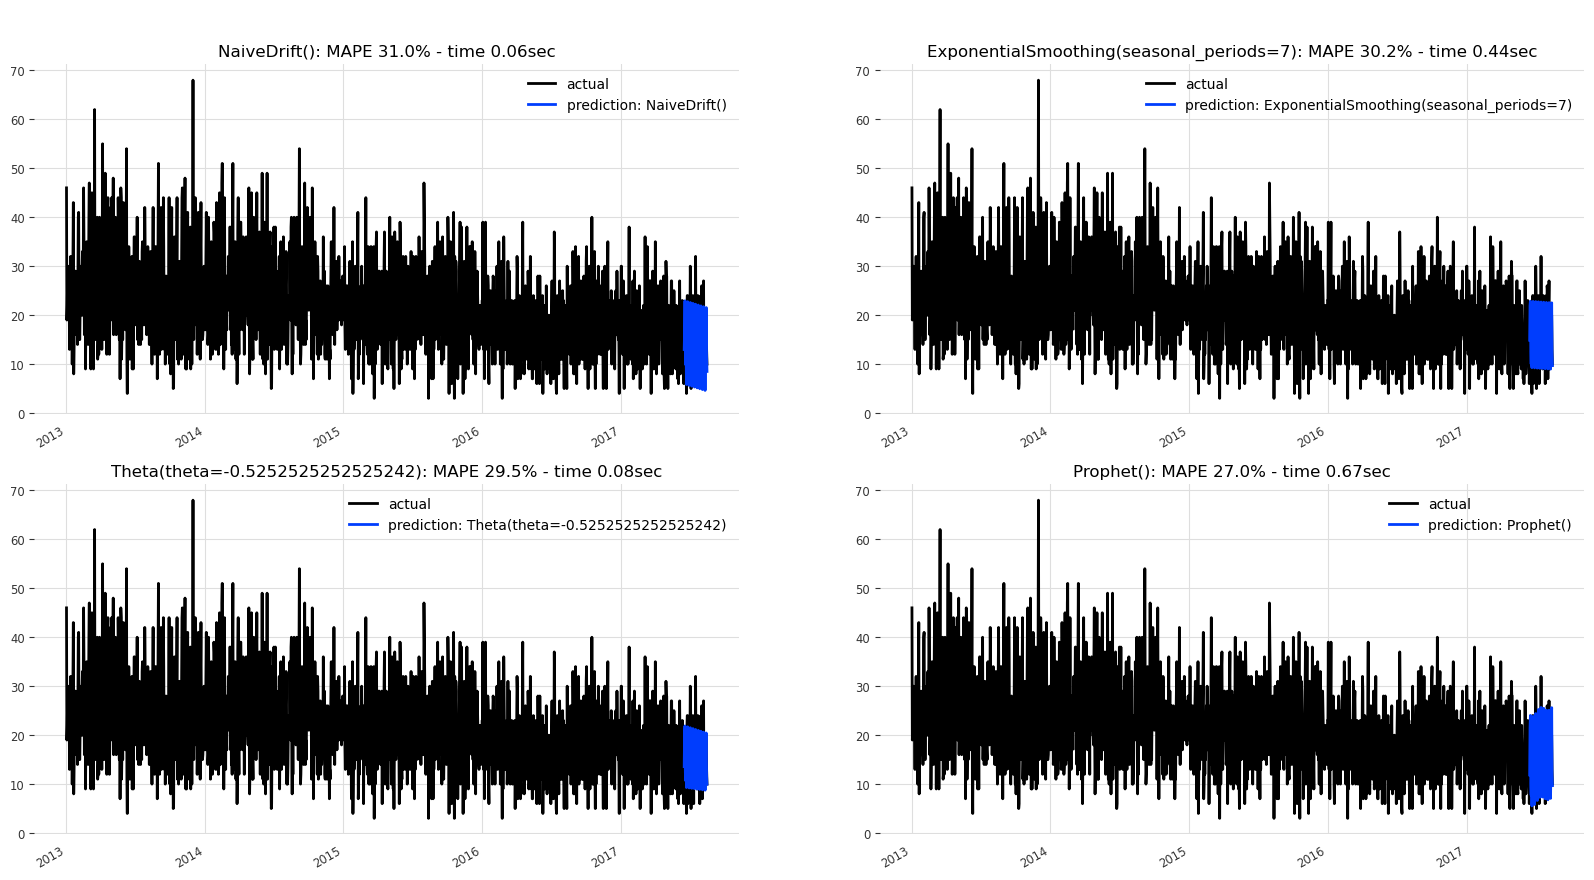

In [104]:
# plot the forecasts

pairs = math.ceil(len(models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 2, figsize=(20, 5 * pairs))
ax = ax.ravel()

for i,m in enumerate(models):
        series.plot(label="actual", ax=ax[i])
        model_predictions[i][0].plot(label="prediction: "+str(m), ax=ax[i])
        
        mape_model =  model_predictions[i][1]["MAPE"]
        time_model =  model_predictions[i][1]["time"]
        ax[i].set_title("\n\n" + str(m) + ": MAPE {:.1f}%".format(mape_model) + " - time {:.2f}sec".format(time_model))

        ax[i].set_xlabel("")
        ax[i].legend()


In [105]:

act = val

resL = {}
resN = {} 
for i,m in enumerate(models):
        pred = model_predictions[i][0]
        resid = pred - act
        sr = resid.pd_series() 

        resL[str(m)] = sm.stats.acorr_ljungbox(sr, lags=[20], return_df=False)[1][0]
        resN[str(m)] = normaltest(sr)[1]

        
print("\nLjung-Box test for white-noise residuals: p-value > alpha?")
[print(key,":",value) for key,value in resL.items()]

print("\ntest for normality of residuals: p-value > alpha?")
[print(key,":",value) for key,value in resN.items()]



Ljung-Box test for white-noise residuals: p-value > alpha?
NaiveDrift() : 0.16908760388480917
ExponentialSmoothing(seasonal_periods=7) : 0.2057848492158811
Theta(theta=-0.5252525252525242) : 0.19848791662518755
Prophet() : 0.1838005422102961

test for normality of residuals: p-value > alpha?
NaiveDrift() : 0.42228985280854847
ExponentialSmoothing(seasonal_periods=7) : 0.01723002426225348
Theta(theta=-0.5252525252525242) : 0.07498327929655887
Prophet() : 0.024196453513154973


[None, None, None, None]

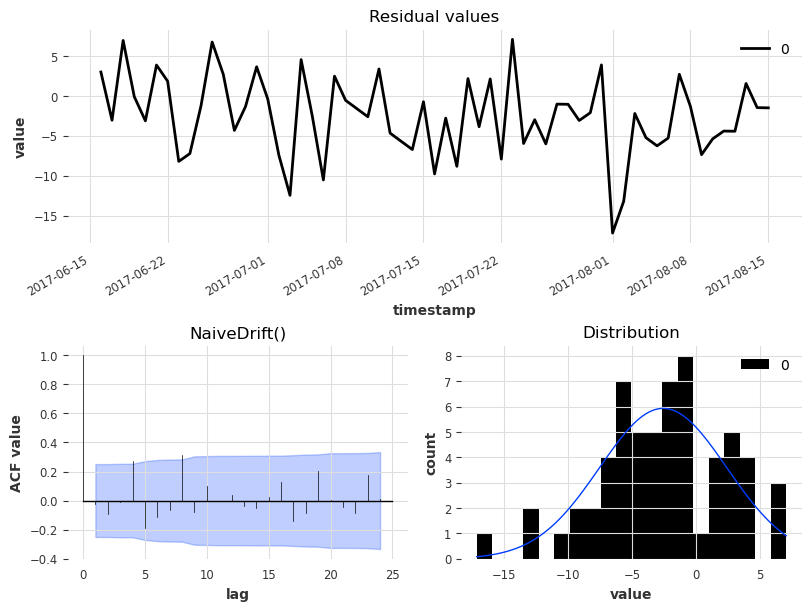

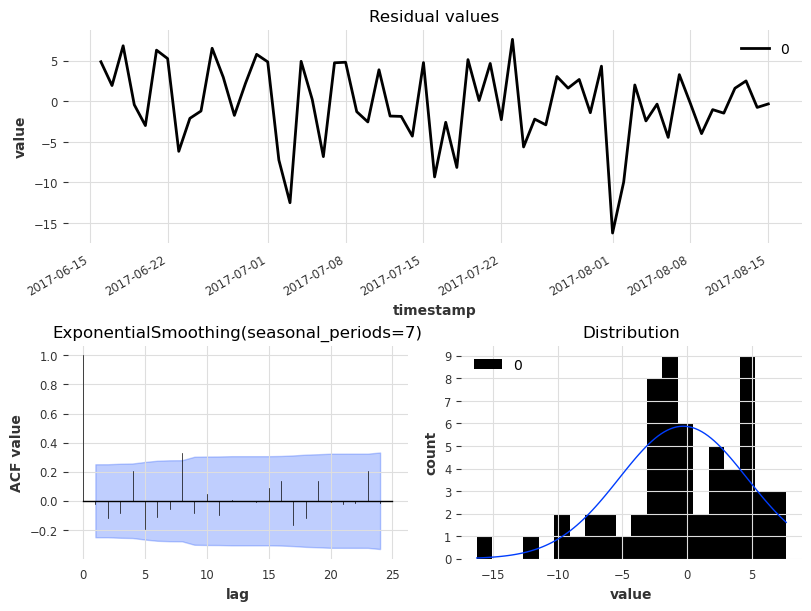

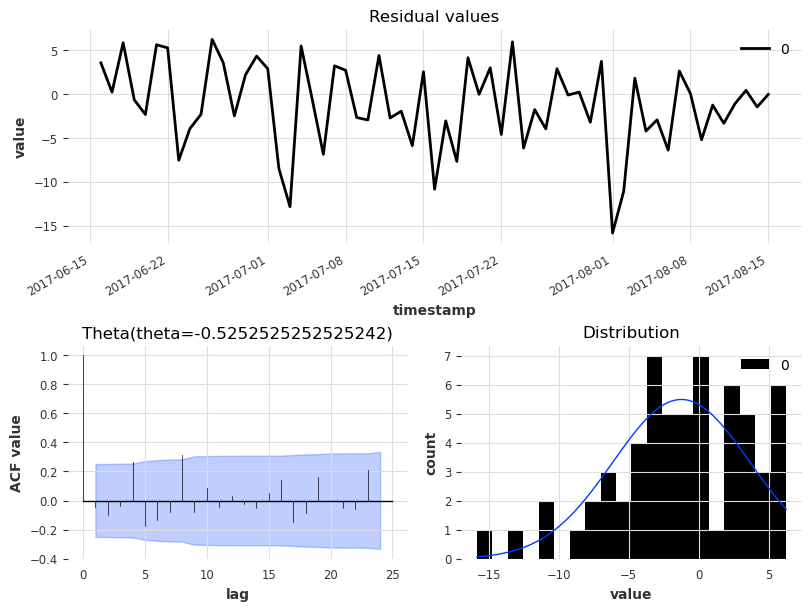

In [106]:
# investigate the residuals in the validation dataset

act = val
df_desc = pd.DataFrame()

for i,m in enumerate(models):
        pred = model_predictions[i][0]
        resid = pred - act
        df_resid=resid.pd_dataframe()
        df_desc = pd.concat([df_desc, df_resid.describe()], axis=1)

        plot_residuals_analysis(resid);
        plt.title(str(m))
    
plt.close()
        

In [107]:
# descriptive statistics of the forecast series
df_desc.columns = [str(m) for m in models]
print(df_desc)

       NaiveDrift()  ExponentialSmoothing(seasonal_periods=7)  \
count        61.000                                    61.000   
mean         -2.566                                    -0.307   
std           5.013                                     4.984   
min         -17.157                                   -16.235   
25%          -5.689                                    -2.541   
50%          -2.492                                    -0.346   
75%           1.548                                     3.890   
max           7.065                                     7.642   

       Theta(theta=-0.5252525252525242)  Prophet()  
count                            61.000     61.000  
mean                             -1.226     -0.969  
std                               4.936      5.122  
min                             -15.846    -17.097  
25%                              -3.933     -3.430  
50%                              -1.095     -0.724  
75%                               2.901    